# Advanced EDA for images

In [1]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from pathlib import Path
from PIL import Image
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler

## 1. Helper

In [2]:
class ImageEDA:
    def __init__(self, img_dir, sample_size=None):
        """
        Initialize EDA with image directory
        sample_size: if None, use all images; otherwise sample N random images
        """
        self.img_dir = img_dir
        self.img_paths = self._get_image_paths()
        
        if sample_size and len(self.img_paths) > sample_size:
            self.img_paths = np.random.choice(self.img_paths, sample_size, replace=False)
        
        self.metadata = []
        self.embeddings = None
        self.df = None
        print(f"✅ Found {len(self.img_paths)} images")

    
    def _get_image_paths(self):
        """Get all image paths from directory"""
        valid_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.gif', '.webp')
        paths = []
        for root, dirs, files in os.walk(self.img_dir):
            for file in files:
                if file.lower().endswith(valid_extensions):
                    paths.append(os.path.join(root, file))
        return np.array(paths)

    
    def extract_metadata(self):
        """Extract basic image properties"""
        print("🗂️ Extracting metadata...")
        
        for idx, path in enumerate(self.img_paths):
            try:
                img = cv2.imread(path)
                if img is None:
                    continue
                
                pil_img = Image.open(path)
                height, width, channels = img.shape
                file_size = os.path.getsize(path) / (1024 * 1024)  # MB
                aspect_ratio = width / height if height > 0 else 0
                
                self.metadata.append({
                    'path': path,
                    'filename': os.path.basename(path),
                    'width': width,
                    'height': height,
                    'channels': channels,
                    'aspect_ratio': aspect_ratio,
                    'file_size_mb': file_size,
                    'format': pil_img.format
                })
            except Exception as e:
                print(f"Error processing {path}: {e}")
                continue
        
        self.df = pd.DataFrame(self.metadata)
        print(f"✅ Successfully processed {len(self.df)} images")
        return self.df

    
    def compute_quality_metrics(self):
        """Compute sharpness, brightness, contrast, saturation"""
        print("🖼️ Computing quality metrics...")
        
        quality_metrics = []
        
        for path in self.img_paths:
            try:
                img = cv2.imread(path)
                if img is None:
                    continue
                
                # Sharpness (Laplacian variance)
                gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                sharpness = cv2.Laplacian(gray, cv2.CV_64F).var()
                
                # Brightness
                brightness = np.mean(gray)
                
                # Contrast (standard deviation)
                contrast = np.std(gray)
                
                # Saturation (HSV analysis)
                hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
                saturation = np.mean(hsv[:, :, 1])
                
                # Entropy (image complexity)
                hist = cv2.calcHist([gray], [0], None, [256], [0, 256])
                hist_normalized = hist / hist.sum()
                entropy = -np.sum(hist_normalized * np.log2(hist_normalized + 1e-10))
                
                quality_metrics.append({
                    'path': path,
                    'sharpness': sharpness,
                    'brightness': brightness,
                    'contrast': contrast,
                    'saturation': saturation,
                    'entropy': entropy
                })
            except Exception as e:
                continue
        
        quality_df = pd.DataFrame(quality_metrics)
        if self.df is not None:
            self.df = self.df.merge(quality_df, on='path', how='left')
        else:
            self.df = quality_df
        
        return quality_df

    
    def analyze_colors(self):
        """Analyze color distribution"""
        print("🎨 Analyzing colors...")
        
        color_metrics = []
        
        for path in self.img_paths:
            try:
                img = cv2.imread(path)
                if img is None:
                    continue
                
                # Convert BGR to RGB
                img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                
                # Mean color per channel
                mean_r = np.mean(img_rgb[:, :, 0])
                mean_g = np.mean(img_rgb[:, :, 1])
                mean_b = np.mean(img_rgb[:, :, 2])
                
                # Dominant color (using kmeans on pixel values)
                pixels = img_rgb.reshape(-1, 3).astype(np.float32)
                kmeans = cv2.kmeans(pixels, 3, None, 
                                    (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0),
                                    10, cv2.KMEANS_PP_CENTERS)
                dominant_colors = kmeans[2]
                
                color_metrics.append({
                    'path': path,
                    'mean_r': mean_r,
                    'mean_g': mean_g,
                    'mean_b': mean_b,
                    'color_variance': np.std([mean_r, mean_g, mean_b])
                })
            except Exception as e:
                continue
        
        color_df = pd.DataFrame(color_metrics)
        if self.df is not None:
            self.df = self.df.merge(color_df, on='path', how='left')
        else:
            self.df = color_df
        
        return color_df

    
    def cluster_images(self, n_clusters=5, method='kmeans', use_embeddings=True):
        """Cluster images using quality metrics or embeddings"""
        print(f"🧩 Clustering with {method}...")
        
        if use_embeddings and self.embeddings is not None:
            features = self.embeddings
            feature_name = "embedding-based"
        else:
            # Use quality metrics
            feature_cols = ['brightness', 'contrast', 'sharpness', 'saturation', 'entropy',
                           'mean_r', 'mean_g', 'mean_b', 'aspect_ratio']
            feature_cols = [col for col in feature_cols if col in self.df.columns]
            features = self.df[feature_cols].fillna(0).values
            features = StandardScaler().fit_transform(features)
            feature_name = "metric-based"
        
        if method == 'kmeans':
            clusterer = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
            labels = clusterer.fit_predict(features)
        elif method == 'dbscan':
            clusterer = DBSCAN(eps=0.5, min_samples=5)
            labels = clusterer.fit_predict(features)
            n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        
        self.df['cluster'] = labels
        
        print(f"Found {n_clusters} clusters ({feature_name})")
        print(self.df['cluster'].value_counts().sort_index())
        
        return labels

        
    def print_summary(self):
        """Print comprehensive summary statistics"""
        print("\n" + "="*60)
        print("IMAGE COLLECTION SUMMARY")
        print("="*60)
        
        if self.df is not None:
            print(f"\nTotal images: {len(self.df)}")
            print(f"\nDimensions:")
            print(f"  Width: {self.df['width'].min()}-{self.df['width'].max()} (mean: {self.df['width'].mean():.0f})")
            print(f"  Height: {self.df['height'].min()}-{self.df['height'].max()} (mean: {self.df['height'].mean():.0f})")
            print(f"  Aspect ratio: {self.df['aspect_ratio'].min():.2f}-{self.df['aspect_ratio'].max():.2f}")
            
            if 'sharpness' in self.df.columns:
                print(f"\nQuality Metrics:")
                print(f"  Sharpness: {self.df['sharpness'].mean():.2f} ± {self.df['sharpness'].std():.2f}")
                print(f"  Brightness: {self.df['brightness'].mean():.2f} ± {self.df['brightness'].std():.2f}")
                print(f"  Contrast: {self.df['contrast'].mean():.2f} ± {self.df['contrast'].std():.2f}")
                
                # Outliers
                print(f"\nOutliers (sharpness < 100):")
                blurry = self.df[self.df['sharpness'] < 100]
                print(f"  Found {len(blurry)} potentially blurry images")
            
            if 'cluster' in self.df.columns:
                print(f"\nClusters: {self.df['cluster'].nunique()}")
            
            print(f"\nFile sizes: {self.df['file_size_mb'].min():.2f}-{self.df['file_size_mb'].max():.2f} MB")

    
    def plot_metadata_distributions(self, figsize=(15, 10)):
        """Plot distributions of image properties"""
        fig, axes = plt.subplots(2, 3, figsize=figsize)
        
        axes[0, 0].hist(self.df['width'], bins=30, edgecolor='black', alpha=0.7)
        axes[0, 0].set_title('Width Distribution')
        axes[0, 0].set_xlabel('Pixels')
        
        axes[0, 1].hist(self.df['height'], bins=30, edgecolor='black', alpha=0.7)
        axes[0, 1].set_title('Height Distribution')
        axes[0, 1].set_xlabel('Pixels')
        
        axes[0, 2].hist(self.df['aspect_ratio'], bins=30, edgecolor='black', alpha=0.7)
        axes[0, 2].set_title('Aspect Ratio Distribution')
        
        axes[1, 0].hist(self.df['file_size_mb'], bins=30, edgecolor='black', alpha=0.7)
        axes[1, 0].set_title('File Size Distribution')
        axes[1, 0].set_xlabel('MB')
        
        if 'format' in self.df.columns:
            format_counts = self.df['format'].value_counts()
            axes[1, 1].bar(format_counts.index, format_counts.values, edgecolor='black')
            axes[1, 1].set_title('Format Distribution')
        
        if 'channels' in self.df.columns:
            channel_counts = self.df['channels'].value_counts()
            axes[1, 2].bar(channel_counts.index, channel_counts.values, edgecolor='black')
            axes[1, 2].set_title('Channel Distribution')
            axes[1, 2].set_xlabel('Channels')
        
        plt.tight_layout()
        return fig

    
    def plot_quality_metrics(self, figsize=(15, 10)):
        """Plot quality metrics"""
        if not all(col in self.df.columns for col in ['sharpness', 'brightness', 'contrast', 'saturation']):
            print("Quality metrics not computed. Run compute_quality_metrics() first.")
            return None
        
        fig, axes = plt.subplots(2, 2, figsize=figsize)
        
        axes[0, 0].hist(self.df['sharpness'], bins=30, edgecolor='black', alpha=0.7, color='blue')
        axes[0, 0].set_title('Sharpness (Laplacian Variance)')
        axes[0, 0].axvline(self.df['sharpness'].mean(), color='red', linestyle='--', label='Mean')
        axes[0, 0].legend()
        
        axes[0, 1].hist(self.df['brightness'], bins=30, edgecolor='black', alpha=0.7, color='green')
        axes[0, 1].set_title('Brightness')
        axes[0, 1].axvline(self.df['brightness'].mean(), color='red', linestyle='--', label='Mean')
        axes[0, 1].legend()
        
        axes[1, 0].hist(self.df['contrast'], bins=30, edgecolor='black', alpha=0.7, color='orange')
        axes[1, 0].set_title('Contrast (Std Dev)')
        axes[1, 0].axvline(self.df['contrast'].mean(), color='red', linestyle='--', label='Mean')
        axes[1, 0].legend()
        
        axes[1, 1].hist(self.df['saturation'], bins=30, edgecolor='black', alpha=0.7, color='purple')
        axes[1, 1].set_title('Saturation (HSV)')
        axes[1, 1].axvline(self.df['saturation'].mean(), color='red', linestyle='--', label='Mean')
        axes[1, 1].legend()
        
        plt.tight_layout()
        return fig

    
    def plot_color_analysis(self, figsize=(15, 5)):
        """Plot color statistics"""
        if not all(col in self.df.columns for col in ['mean_r', 'mean_g', 'mean_b']):
            print("❌ Color analysis not computed. Run analyze_colors() first.")
            return None
        
        fig, axes = plt.subplots(1, 3, figsize=figsize)
        
        # Mean RGB values scatter
        axes[0].scatter(self.df['mean_r'], self.df['mean_g'], alpha=0.5, c=self.df['mean_b'], cmap='coolwarm')
        axes[0].set_xlabel('Mean Red')
        axes[0].set_ylabel('Mean Green')
        axes[0].set_title('R vs G (colored by B)')
        
        # RGB histograms
        axes[1].hist(self.df['mean_r'], bins=30, alpha=0.5, label='Red', edgecolor='black')
        axes[1].hist(self.df['mean_g'], bins=30, alpha=0.5, label='Green', edgecolor='black')
        axes[1].hist(self.df['mean_b'], bins=30, alpha=0.5, label='Blue', edgecolor='black')
        axes[1].set_title('Mean Channel Values Distribution')
        axes[1].legend()
        
        # Color variance
        axes[2].hist(self.df['color_variance'], bins=30, edgecolor='black', alpha=0.7)
        axes[2].set_title('Color Variance (R, G, B)')
        
        plt.tight_layout()
        return fig

    
    def plot_sample_grid(self, cluster_id=None, n_samples=9, figsize=(12, 12)):
        """Plot grid of sample images"""
        if cluster_id is not None:
            paths = self.df[self.df['cluster'] == cluster_id]['path'].values
        else:
            paths = self.df['path'].values
        
        if len(paths) < n_samples:
            n_samples = len(paths)
        
        sample_indices = np.random.choice(len(paths), n_samples, replace=False)
        sample_paths = paths[sample_indices]
        
        grid_size = int(np.ceil(np.sqrt(n_samples)))
        fig, axes = plt.subplots(grid_size, grid_size, figsize=figsize)
        axes = axes.flatten()
        
        for idx, path in enumerate(sample_paths):
            try:
                img = Image.open(path)
                axes[idx].imshow(img)
                axes[idx].set_title(os.path.basename(path)[:20], fontsize=8)
                axes[idx].axis('off')
            except:
                axes[idx].axis('off')
        
        for idx in range(len(sample_paths), len(axes)):
            axes[idx].axis('off')
        
        if cluster_id is not None:
            fig.suptitle(f'Sample Images from Cluster {cluster_id}')
        
        plt.tight_layout()
        return fig

    
    def plot_quality_boxplots(self, figsize=(15, 5)):
        """Boxplots of quality metrics by cluster"""
        if 'cluster' not in self.df.columns:
            print("❌ Clustering not performed. Run cluster_images() first.")
            return None
        
        metrics = ['sharpness', 'brightness', 'contrast', 'saturation']
        metrics = [m for m in metrics if m in self.df.columns]
        
        fig, axes = plt.subplots(1, len(metrics), figsize=figsize)
        if len(metrics) == 1:
            axes = [axes]
        
        for idx, metric in enumerate(metrics):
            data_by_cluster = [self.df[self.df['cluster'] == c][metric].values 
                              for c in sorted(self.df['cluster'].unique())]
            axes[idx].boxplot(data_by_cluster)
            axes[idx].set_title(f'{metric.capitalize()} by Cluster')
            axes[idx].set_xlabel('Cluster')
            axes[idx].set_ylabel(metric.capitalize())
        
        plt.tight_layout()
        return fig

## 2. EDA

In [21]:
PROJECT_ID = "86959367-35e2-4a1e-9739-eab331a91cbc"
TASK = "object_detection_projects"

IMAGES_DIR = os.path.join(TASK, PROJECT_ID, "images")

### Images

In [4]:
eda = ImageEDA(img_dir=IMAGES_DIR)

✅ Found 919 images


### Metadata

In [5]:
eda.extract_metadata()

🗂️ Extracting metadata...
✅ Successfully processed 919 images


,path,filename,width,height,channels,aspect_ratio,file_size_mb,format
0,object_detection_projects/86959367-35e2-4a1e-9...,002cecd2-52da-4f79-97ac-0f7260395807.jpg,1528,1146,3,1.333333,0.124127,JPEG
1,object_detection_projects/86959367-35e2-4a1e-9...,0046ed3b-0093-47e9-8acd-abc13a493557.jpg,1920,1080,3,1.777778,0.111745,JPEG
2,object_detection_projects/86959367-35e2-4a1e-9...,01165f01-95e1-463b-a489-fe3f1312de48.jpg,632,480,3,1.316667,0.039995,JPEG
3,object_detection_projects/86959367-35e2-4a1e-9...,0123605c-ff02-4b6e-9376-98e10d84c543.jpg,632,480,3,1.316667,0.032634,JPEG
4,object_detection_projects/86959367-35e2-4a1e-9...,0140927d-1917-482f-bc7c-3b856871db58.jpg,632,480,3,1.316667,0.038855,JPEG
...,...,...,...,...,...,...,...,...
914,object_detection_projects/86959367-35e2-4a1e-9...,ff665dac-42b2-4c3e-a839-aad884e72fbc.jpg,632,480,3,1.316667,0.039932,JPEG
915,object_detection_projects/86959367-35e2-4a1e-9...,ff7bda74-3067-4bf4-b5f6-16d598267ab9.jpg,632,480,3,1.316667,0.032551,JPEG
916,object_detection_projects/86959367-35e2-4a1e-9...,ff987440-eb6b-42e3-a1c7-6fcd937b0193.jpg,1920,1080,3,1.777778,0.093966,JPEG
917,object_detection_projects/86959367-35e2-4a1e-9...,ffc18b36-5dfe-4124-9f74-4d0229131c36.jpg,1920,1080,3,1.777778,0.101621,JPEG


### Quality metrics

In [6]:
eda.compute_quality_metrics()

🖼️ Computing quality metrics...


,path,sharpness,brightness,contrast,saturation,entropy
0,object_detection_projects/86959367-35e2-4a1e-9...,261.439908,163.482282,58.625546,15.998230,7.163504
1,object_detection_projects/86959367-35e2-4a1e-9...,87.090271,142.843602,54.894304,30.264462,7.348130
2,object_detection_projects/86959367-35e2-4a1e-9...,862.250512,112.289540,73.971653,27.823616,7.796780
3,object_detection_projects/86959367-35e2-4a1e-9...,651.654523,127.913466,73.828534,23.501164,7.732467
4,object_detection_projects/86959367-35e2-4a1e-9...,778.839924,124.791311,73.729222,15.782058,7.638474
...,...,...,...,...,...,...
914,object_detection_projects/86959367-35e2-4a1e-9...,837.286709,104.500547,81.341086,37.002954,7.664952
915,object_detection_projects/86959367-35e2-4a1e-9...,495.540262,113.606438,67.401462,28.933567,7.734739
916,object_detection_projects/86959367-35e2-4a1e-9...,77.218164,164.022301,39.188389,9.613595,5.465157
917,object_detection_projects/86959367-35e2-4a1e-9...,65.209960,162.928924,57.329648,27.655545,6.327214


### Colors analysis

In [7]:
eda.analyze_colors()

🎨 Analyzing colors...


,path,mean_r,mean_g,mean_b,color_variance
0,object_detection_projects/86959367-35e2-4a1e-9...,163.721260,163.141850,164.557540,0.581116
1,object_detection_projects/86959367-35e2-4a1e-9...,148.081440,141.655809,134.679147,5.473004
2,object_detection_projects/86959367-35e2-4a1e-9...,112.476909,112.438393,111.091960,0.643985
3,object_detection_projects/86959367-35e2-4a1e-9...,126.529328,128.786435,127.079045,0.961012
4,object_detection_projects/86959367-35e2-4a1e-9...,123.963667,125.306590,124.302911,0.570175
...,...,...,...,...,...
914,object_detection_projects/86959367-35e2-4a1e-9...,103.408706,105.314837,103.132048,0.970363
915,object_detection_projects/86959367-35e2-4a1e-9...,112.088835,114.688100,112.107262,1.220985
916,object_detection_projects/86959367-35e2-4a1e-9...,164.988385,164.046931,160.780356,1.803218
917,object_detection_projects/86959367-35e2-4a1e-9...,167.261616,162.300383,154.241983,5.365140


### Clustering images

In [8]:
eda.cluster_images(n_clusters=10, method='kmeans', use_embeddings=False)

🧩 Clustering with kmeans...
Found 10 clusters (metric-based)
cluster
0    160
1    156
2    123
3      2
4    173
5     52
6     37
7    142
8     73
9      1
Name: count, dtype: int64


array([6, 4, 7, 7, 7, 2, 4, 1, 2, 0, 4, 1, 4, 6, 0, 0, 5, 7, 0, 1, 7, 0,
       1, 0, 7, 1, 4, 1, 4, 0, 7, 0, 1, 5, 1, 5, 4, 1, 3, 1, 7, 0, 1, 5,
       4, 2, 2, 0, 7, 0, 7, 1, 7, 5, 4, 4, 7, 4, 1, 5, 7, 4, 4, 8, 1, 1,
       4, 4, 4, 2, 1, 2, 0, 8, 1, 2, 4, 0, 8, 4, 7, 4, 8, 0, 6, 4, 8, 1,
       0, 0, 8, 7, 4, 1, 4, 4, 8, 7, 4, 7, 0, 8, 7, 0, 1, 0, 0, 2, 2, 8,
       7, 2, 0, 6, 0, 1, 7, 5, 1, 0, 0, 1, 1, 0, 4, 6, 0, 7, 1, 4, 7, 7,
       0, 2, 1, 1, 8, 5, 7, 2, 4, 8, 7, 8, 1, 2, 1, 5, 2, 4, 2, 0, 5, 5,
       2, 2, 7, 7, 2, 4, 1, 2, 7, 2, 6, 0, 1, 4, 4, 2, 4, 7, 0, 1, 1, 7,
       7, 6, 1, 4, 1, 8, 1, 7, 5, 7, 0, 1, 0, 4, 1, 1, 7, 2, 7, 0, 7, 0,
       4, 7, 8, 4, 7, 1, 0, 4, 1, 7, 6, 0, 4, 0, 7, 7, 1, 7, 6, 1, 4, 8,
       8, 4, 1, 7, 8, 0, 4, 4, 0, 2, 0, 8, 0, 4, 1, 8, 3, 1, 0, 7, 2, 8,
       2, 0, 1, 0, 7, 0, 2, 6, 4, 1, 7, 1, 4, 5, 1, 4, 2, 0, 1, 7, 7, 2,
       2, 5, 7, 1, 2, 4, 1, 7, 2, 0, 8, 7, 1, 7, 4, 0, 4, 1, 4, 7, 1, 7,
       4, 0, 7, 4, 0, 4, 4, 1, 0, 7, 0, 8, 4, 1, 1,

### Results

In [9]:
eda.print_summary()


IMAGE COLLECTION SUMMARY

Total images: 919

Dimensions:
  Width: 262-4032 (mean: 1276)
  Height: 192-3024 (mean: 883)
  Aspect ratio: 0.56-2.53

Quality Metrics:
  Sharpness: 347.91 ± 309.12
  Brightness: 140.77 ± 21.42
  Contrast: 61.10 ± 11.60

Outliers (sharpness < 100):
  Found 321 potentially blurry images

Clusters: 10

File sizes: 0.01-0.97 MB


### Plots

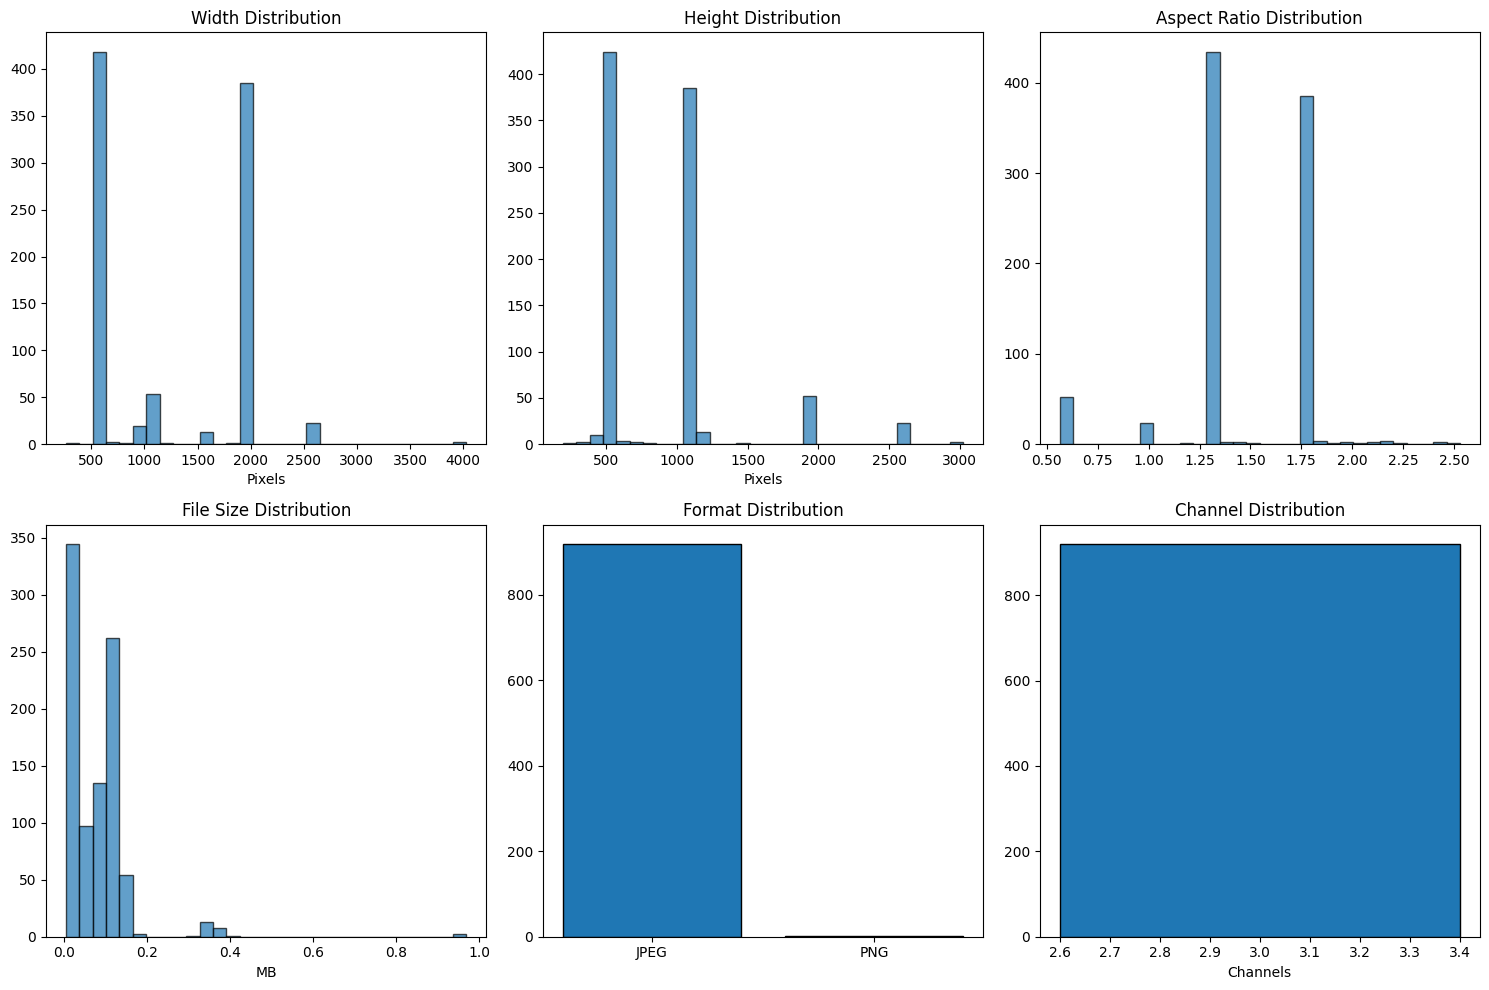

In [22]:
fig1 = eda.plot_metadata_distributions()
plt.savefig(os.path.join(TASK, PROJECT_ID, "metadata.png"), dpi=300)

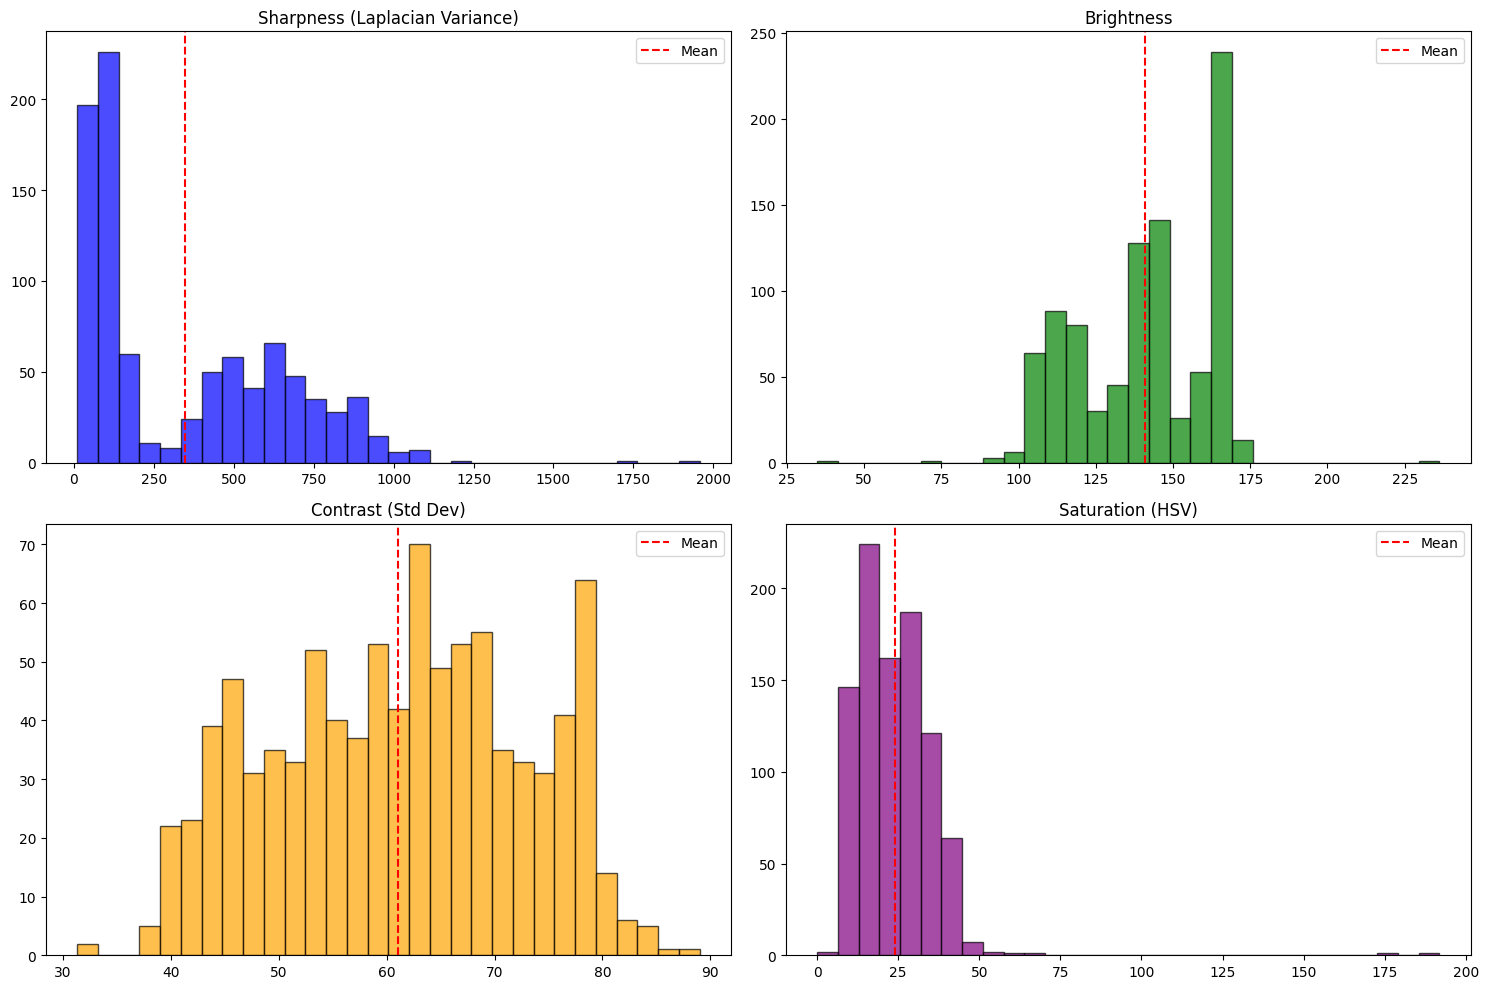

In [23]:
fig2 = eda.plot_quality_metrics()
plt.savefig(os.path.join(TASK, PROJECT_ID, "quality_metrics.png"), dpi=300)

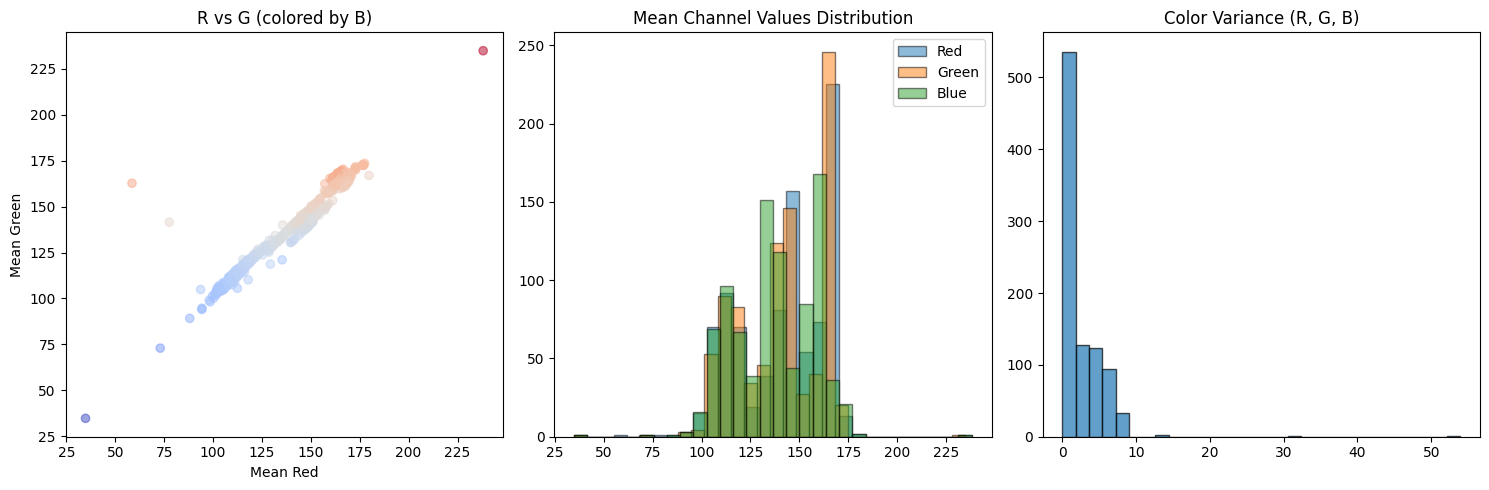

In [24]:
fig3 = eda.plot_color_analysis()
plt.savefig(os.path.join(TASK, PROJECT_ID, "color_analysis.png"), dpi=300)

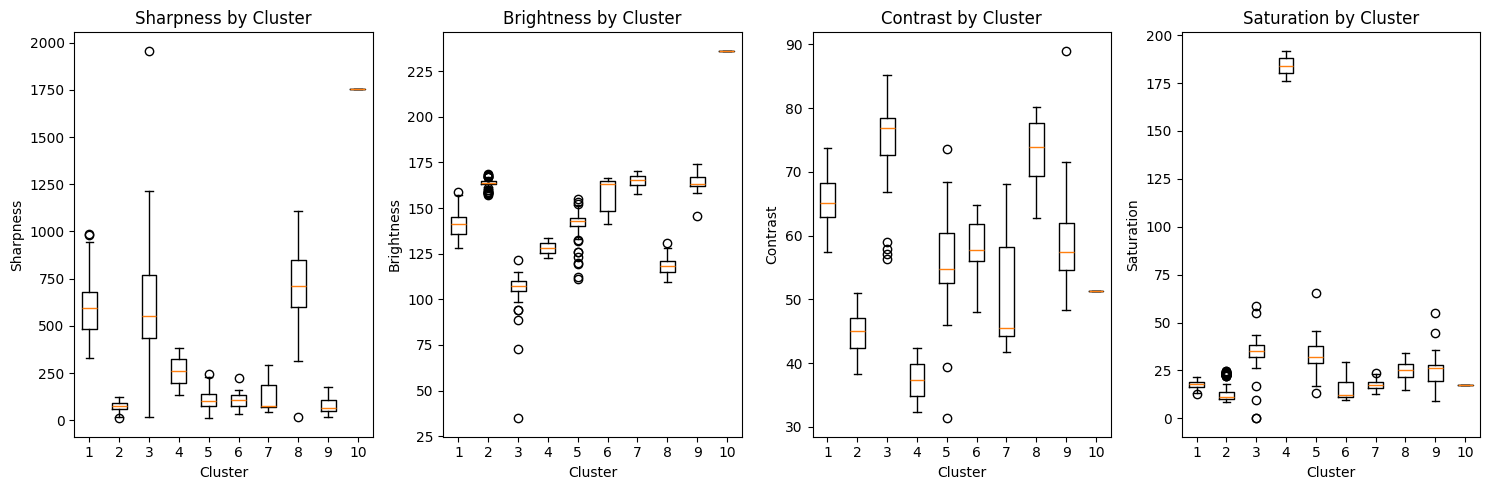

In [25]:
fig4 = eda.plot_quality_boxplots()
plt.savefig(os.path.join(TASK, PROJECT_ID, "quality_boxplot.png"), dpi=300)

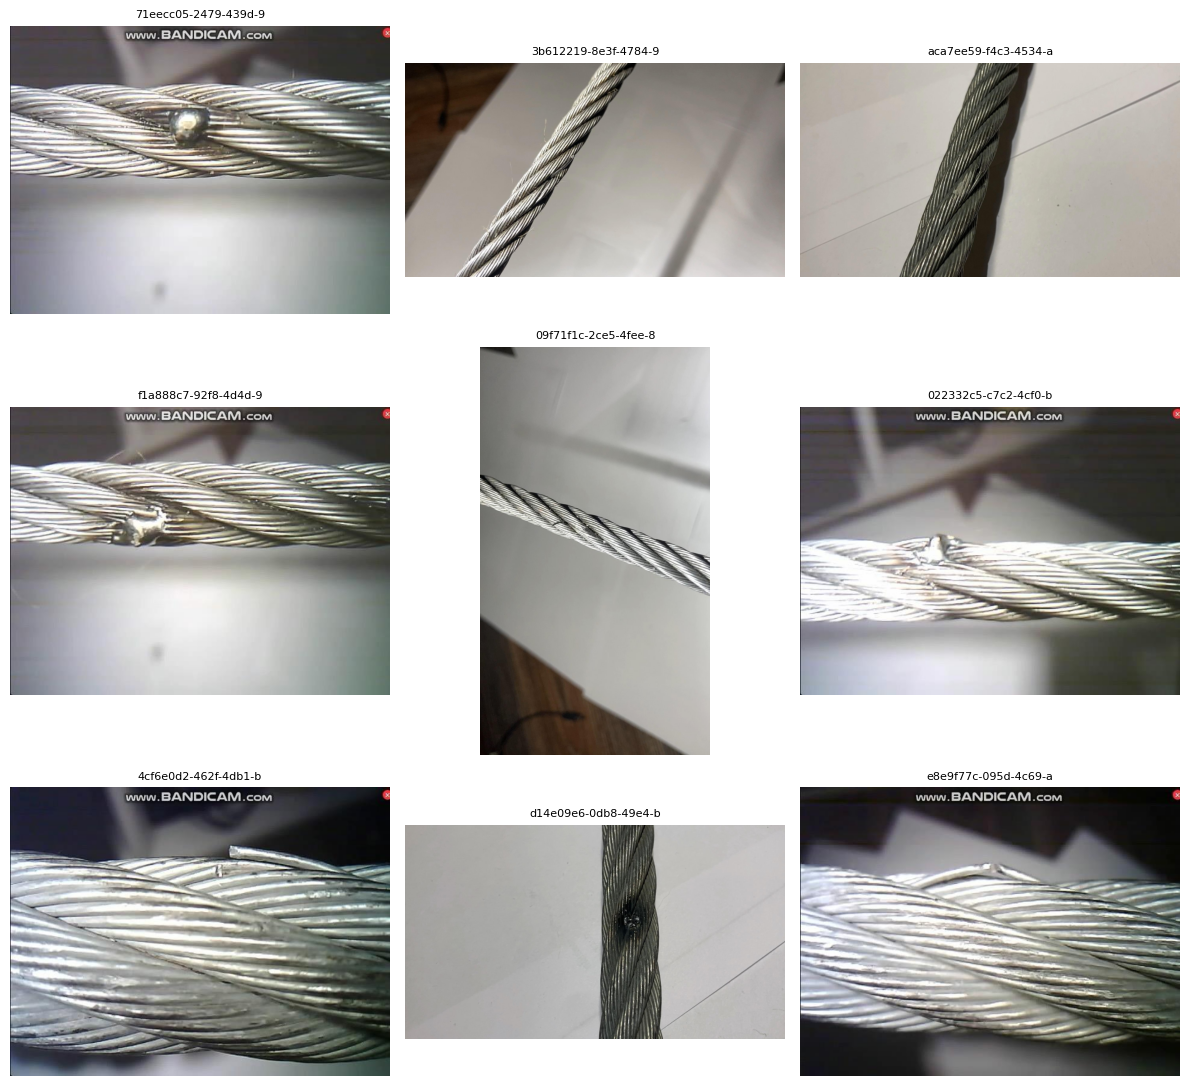

In [26]:
fig5 = eda.plot_sample_grid(n_samples=9)
plt.savefig(os.path.join(TASK, PROJECT_ID, "sample_grid.png"), dpi=300)

### Summary results

In [27]:
eda.df

,path,filename,width,height,channels,aspect_ratio,file_size_mb,format,sharpness,brightness,contrast,saturation,entropy,mean_r,mean_g,mean_b,color_variance,cluster
0,object_detection_projects/86959367-35e2-4a1e-9...,002cecd2-52da-4f79-97ac-0f7260395807.jpg,1528,1146,3,1.333333,0.124127,JPEG,261.439908,163.482282,58.625546,15.998230,7.163504,163.721260,163.141850,164.557540,0.581116,6
1,object_detection_projects/86959367-35e2-4a1e-9...,0046ed3b-0093-47e9-8acd-abc13a493557.jpg,1920,1080,3,1.777778,0.111745,JPEG,87.090271,142.843602,54.894304,30.264462,7.348130,148.081440,141.655809,134.679147,5.473004,4
2,object_detection_projects/86959367-35e2-4a1e-9...,01165f01-95e1-463b-a489-fe3f1312de48.jpg,632,480,3,1.316667,0.039995,JPEG,862.250512,112.289540,73.971653,27.823616,7.796780,112.476909,112.438393,111.091960,0.643985,7
3,object_detection_projects/86959367-35e2-4a1e-9...,0123605c-ff02-4b6e-9376-98e10d84c543.jpg,632,480,3,1.316667,0.032634,JPEG,651.654523,127.913466,73.828534,23.501164,7.732467,126.529328,128.786435,127.079045,0.961012,7
4,object_detection_projects/86959367-35e2-4a1e-9...,0140927d-1917-482f-bc7c-3b856871db58.jpg,632,480,3,1.316667,0.038855,JPEG,778.839924,124.791311,73.729222,15.782058,7.638474,123.963667,125.306590,124.302911,0.570175,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
914,object_detection_projects/86959367-35e2-4a1e-9...,ff665dac-42b2-4c3e-a839-aad884e72fbc.jpg,632,480,3,1.316667,0.039932,JPEG,837.286709,104.500547,81.341086,37.002954,7.664952,103.408706,105.314837,103.132048,0.970363,2
915,object_detection_projects/86959367-35e2-4a1e-9...,ff7bda74-3067-4bf4-b5f6-16d598267ab9.jpg,632,480,3,1.316667,0.032551,JPEG,495.540262,113.606438,67.401462,28.933567,7.734739,112.088835,114.688100,112.107262,1.220985,7
916,object_detection_projects/86959367-35e2-4a1e-9...,ff987440-eb6b-42e3-a1c7-6fcd937b0193.jpg,1920,1080,3,1.777778,0.093966,JPEG,77.218164,164.022301,39.188389,9.613595,5.465157,164.988385,164.046931,160.780356,1.803218,1
917,object_detection_projects/86959367-35e2-4a1e-9...,ffc18b36-5dfe-4124-9f74-4d0229131c36.jpg,1920,1080,3,1.777778,0.101621,JPEG,65.209960,162.928924,57.329648,27.655545,6.327214,167.261616,162.300383,154.241983,5.365140,8


In [28]:
eda.df.describe()

,width,height,channels,aspect_ratio,file_size_mb,sharpness,brightness,contrast,saturation,entropy,mean_r,mean_g,mean_b,color_variance,cluster
count,919.000000,919.000000,919.0,919.000000,919.000000,919.000000,919.000000,919.000000,919.000000,919.000000,919.000000,919.000000,919.000000,919.000000,919.000000
mean,1276.142546,883.103373,3.0,1.475372,0.082334,347.911753,140.767960,61.097881,24.032811,7.082981,141.967231,140.707354,137.692856,2.579669,3.448313
std,657.456771,492.810122,0.0,0.333879,0.072867,309.119285,21.422890,11.599719,12.267153,0.734417,22.694743,21.183351,20.636963,2.901129,2.731502
min,262.000000,192.000000,3.0,0.562500,0.005884,10.740479,34.747257,31.331045,0.000000,1.040896,34.747257,34.747257,34.747257,0.000000,0.000000
25%,632.000000,480.000000,3.0,1.316667,0.032816,80.371594,120.522913,51.787642,16.507514,6.497609,119.121175,121.056022,120.281876,0.872997,1.000000
50%,1080.000000,1080.000000,3.0,1.316667,0.090148,161.841135,142.755073,62.011261,22.131919,7.366848,147.044287,141.946999,137.310045,1.568831,4.000000
75%,1920.000000,1080.000000,3.0,1.777778,0.109448,607.724279,162.901771,69.852055,30.966271,7.644493,163.804458,162.675497,156.267306,4.305277,6.000000
max,4032.000000,3024.000000,3.0,2.529617,0.969583,1956.934483,236.239482,89.003338,191.859245,7.892781,238.121445,234.907859,238.095321,53.921634,9.000000


### Exports

In [29]:
csv_file = os.path.join(TASK, PROJECT_ID, "advanced_eda.csv")
eda.df.to_csv(csv_file, index=False)

In [30]:
!ls $csv_file -lh

-rwxrwxrwx 1 root root 329K Jan 12 17:21 object_detection_projects/86959367-35e2-4a1e-9739-eab331a91cbc/advanced_eda.csv


In [31]:
excel_file = os.path.join(TASK, PROJECT_ID, "advanced_eda.xlsx")
eda.df.to_excel(excel_file, index=False)

In [32]:
!ls $excel_file -lh

-rwxrwxrwx 1 root root 181K Jan 12 17:21 object_detection_projects/86959367-35e2-4a1e-9739-eab331a91cbc/advanced_eda.xlsx
